In [1]:
from pyspark.sql import SparkSession

# Creating a Spark session with increased settings for memory and using KryoSerializer for better performance
spark = SparkSession.builder \
    .appName("Toxic Comment Classification") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memoryOverhead", "1g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/05 09:39:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("Toxic Comment Detection").getOrCreate()

# Define the path to your data files
path_to_data = "downloads/266_Data/train.csv"

# Define the schema for the DataFrame
schema = StructType([
    StructField("id", StringType(), True),
    StructField("target", DoubleType(), True),
    StructField("comment_text", StringType(), True),
    StructField("severe_toxicity", DoubleType(), True),
    StructField("obscene", DoubleType(), True),
    StructField("identity_attack", DoubleType(), True),
    StructField("insult", DoubleType(), True),
    StructField("threat", DoubleType(), True),
    # Add more fields here if your CSV has more columns
])

# Load data into DataFrame using the defined schema
df = spark.read.csv(path_to_data, header=True, schema=schema)

# Convert floating point values to 0 or 1 based on the condition
int_cols = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
for col_name in int_cols:
    df = df.withColumn(col_name, when(col(col_name) > 0, 1).otherwise(0))

# Show the first few rows and print the schema to confirm setup
df.show(10)
df.printSchema()

# Count the number of rows and columns in the DataFrame
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))


24/05/05 09:43:23 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 45, schema size: 8
CSV file: file:///Users/ananya/downloads/266_Data/train.csv


+------+------+--------------------+---------------+-------+---------------+------+------+
|    id|target|        comment_text|severe_toxicity|obscene|identity_attack|insult|threat|
+------+------+--------------------+---------------+-------+---------------+------+------+
| 59848|     0|This is so cool. ...|              0|      0|              0|     0|     0|
| 59849|     0|Thank you!! This ...|              0|      0|              0|     0|     0|
| 59852|     0|This is such an u...|              0|      0|              0|     0|     0|
| 59855|     0|Is this something...|              0|      0|              0|     0|     0|
| 59856|     1|haha you guys are...|              1|      0|              1|     1|     0|
| 59859|     1|ur a sh*tty comment.|              1|      1|              0|     1|     0|
| 59861|     1|hahahahahahahahhh...|              1|      1|              0|     1|     0|
| 59863|     0| FFFFUUUUUUUUUUUUUUU|              0|      0|              0|     0|     0|

Number of rows: 3053644
Number of columns: 8


In [12]:
# Count the number of rows and columns in the DataFrame
from pyspark.sql.functions import col, when, count, lit

print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

# Check for missing values in key columns
from pyspark.sql.functions import col, when, count
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Show summary statistics for numerical columns
df.describe().show()


# Remove rows where 'comment_text' is null (if that is your chosen approach)
df = df.filter(df['comment_text'].isNotNull())

# Alternatively, replace nulls in 'comment_text' with a placeholder text
# df = df.withColumn('comment_text', when(col('comment_text').isNull(), lit("no text")).otherwise(col('comment_text')))

# Count the number of rows and columns again after cleaning
print("Number of rows after cleaning:", df.count())
print("Number of columns:", len(df.columns))

# Recheck for missing values in key columns
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Show summary statistics for numerical columns
df.describe().show()

df.show(10)





Number of rows: 2534236
Number of columns: 8


24/05/05 09:49:08 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 45, schema size: 8
CSV file: file:///Users/ananya/downloads/266_Data/train.csv


+---+------+------------+---------------+-------+---------------+------+------+
| id|target|comment_text|severe_toxicity|obscene|identity_attack|insult|threat|
+---+------+------------+---------------+-------+---------------+------+------+
| 21|     0|           0|              0|      0|              0|     0|     0|
+---+------+------------+---------------+-------+---------------+------+------+



+-------+--------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|summary|                  id|             target|     comment_text|    severe_toxicity|            obscene|    identity_attack|             insult|              threat|
+-------+--------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|  count|             2534215|            2534236|          2534236|            2534236|            2534236|            2534236|            2534236|             2534236|
|   mean|  3737827.0621518567| 0.2204115954473064|2.775874145945823|0.04932887071290914|0.07963701880961363|0.07770625940125545|0.12412932339371709|0.039559456972436666|
| stddev|   2445451.996721021|0.41452429584199885|73.85617464381441| 0.2165538079367498|0.27073048030589303| 0.2677088435802097|0.32972909693950625| 0

Number of rows after cleaning: 2534236
Number of columns: 8


24/05/05 09:49:16 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 45, schema size: 8
CSV file: file:///Users/ananya/downloads/266_Data/train.csv


+---+------+------------+---------------+-------+---------------+------+------+
| id|target|comment_text|severe_toxicity|obscene|identity_attack|insult|threat|
+---+------+------------+---------------+-------+---------------+------+------+
| 21|     0|           0|              0|      0|              0|     0|     0|
+---+------+------------+---------------+-------+---------------+------+------+



+-------+--------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|summary|                  id|             target|     comment_text|    severe_toxicity|            obscene|    identity_attack|             insult|              threat|
+-------+--------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|  count|             2534215|            2534236|          2534236|            2534236|            2534236|            2534236|            2534236|             2534236|
|   mean|  3737827.0621518567| 0.2204115954473064|2.775874145945823|0.04932887071290914|0.07963701880961363|0.07770625940125545|0.12412932339371709|0.039559456972436666|
| stddev|   2445451.996721021|0.41452429584199885|73.85617464381441| 0.2165538079367498|0.27073048030589303| 0.2677088435802097|0.32972909693950625| 0

24/05/05 09:49:22 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 45, schema size: 8
CSV file: file:///Users/ananya/downloads/266_Data/train.csv


In [13]:
df.count()

2534236

In [14]:
from pyspark.sql.functions import length

# Add a new column that contains the length of each comment
df = df.withColumn("comment_length", length(col("comment_text")))


In [15]:
# Print the column names of the DataFrame to verify
print(df.columns)


['id', 'target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'comment_length']


In [16]:
from pyspark.sql.functions import col, lower, regexp_replace

# Clean the text data: lowercasing and removing punctuation
df = df.withColumn("clean_comment", lower(col("comment_text")))
df = df.withColumn("clean_comment", regexp_replace(col("clean_comment"), "[^a-zA-Z\\s]", ""))

# Show the cleaned text data
df.select("comment_text", "clean_comment").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment_text                                                                                                                                                                               

In [17]:
from pyspark.ml.feature import Tokenizer

# Tokenize words
tokenizer = Tokenizer(inputCol="clean_comment", outputCol="words")
df = tokenizer.transform(df)

# Show the tokenized words
df.select("clean_comment", "words").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_comment                                                                                                            

In [18]:
from pyspark.ml.feature import StopWordsRemover

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# Show the filtered words
df.select("words", "filtered_words").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                                                   

In [19]:
df.show(10)

+------+------+--------------------+---------------+-------+---------------+------+------+--------------+--------------------+--------------------+--------------------+
|    id|target|        comment_text|severe_toxicity|obscene|identity_attack|insult|threat|comment_length|       clean_comment|               words|      filtered_words|
+------+------+--------------------+---------------+-------+---------------+------+------+--------------+--------------------+--------------------+--------------------+
| 59848|     0|This is so cool. ...|              0|      0|              0|     0|     0|           101|this is so cool i...|[this, is, so, co...|[cool, like, want...|
| 59849|     0|Thank you!! This ...|              0|      0|              0|     0|     0|           114|thank you this wo...|[thank, you, this...|[thank, make, lif...|
| 59852|     0|This is such an u...|              0|      0|              0|     0|     0|            86|this is such an u...|[this, is, such, ...|[urgent,

24/05/05 09:50:01 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 45, schema size: 8
CSV file: file:///Users/ananya/downloads/266_Data/train.csv


+-------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|summary|             target|    severe_toxicity|            obscene|    identity_attack|             insult|              threat|
+-------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|  count|            2534236|            2534236|            2534236|            2534236|            2534236|             2534236|
|   mean| 0.2204115954473064|0.04932887071290914|0.07963701880961363|0.07770625940125545|0.12412932339371709|0.039559456972436666|
| stddev|0.41452429584199885| 0.2165538079367498|0.27073048030589303| 0.2677088435802097|0.32972909693950625| 0.19492183389496837|
|    min|                  0|                  0|                  0|                  0|                  0|                   0|
|    max|                  1|                  1|                  1|              

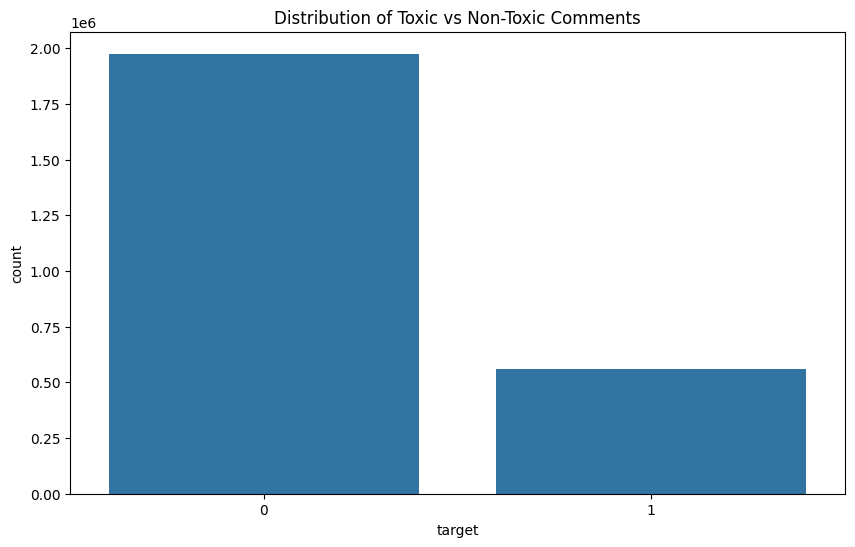

+-------+------------------+
|summary|    comment_length|
+-------+------------------+
|  count|           2534236|
|   mean|139.32952140211094|
| stddev| 168.3587729101458|
|    min|                 1|
|    max|              1016|
+-------+------------------+



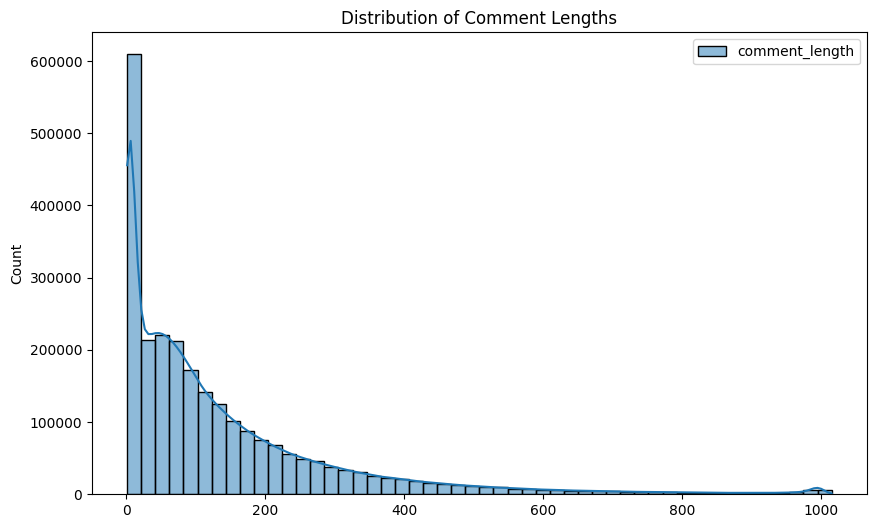

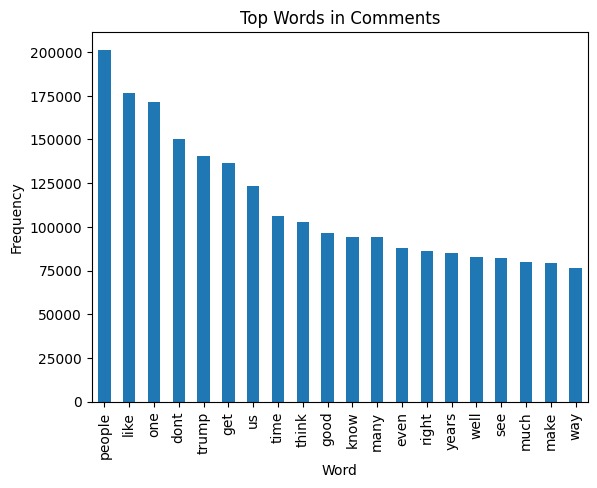

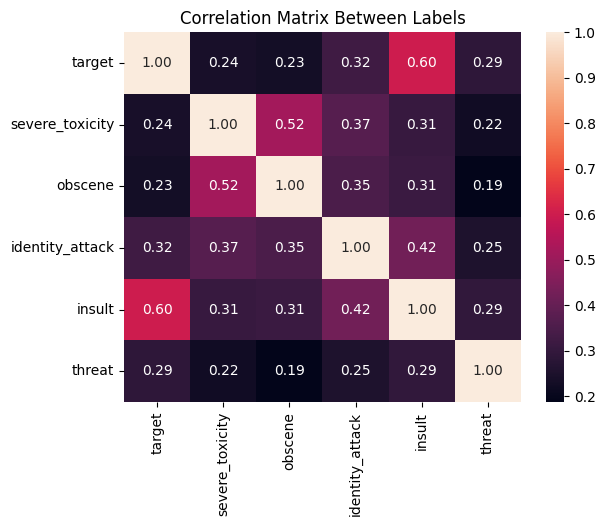

In [24]:
from pyspark.sql.functions import length, col, concat_ws

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate basic statistics for numerical columns
numeric_cols = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
df.describe(numeric_cols).show()

# Distribution of Target Classes
toxic_distribution = df.groupBy('target').count().toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='target', y='count', data=toxic_distribution)
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.show()

# Comment Length Analysis
df = df.withColumn("comment_length", length(col("comment_text")))
df.select("comment_length").describe().show()

comment_length_distribution = df.select("comment_length").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(comment_length_distribution, bins=50, kde=True)
plt.title('Distribution of Comment Lengths')
plt.show()


# Convert words into a single string per document for frequency analysis
df_with_word_string = df.withColumn("words_string", concat_ws(" ", col("filtered_words")))
top_words = df_with_word_string.select("words_string").rdd.flatMap(lambda x: x[0].split()).countByValue()

# Display the most common words
top_words_df = pd.DataFrame(list(top_words.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
top_words_df.head(20).plot(x='Word', y='Frequency', kind='bar', legend=None)
plt.title('Top Words in Comments')
plt.ylabel('Frequency')
plt.show()

# Correlation Matrix
correlation_data = df.select(numeric_cols).toPandas()
sns.heatmap(correlation_data.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix Between Labels')
plt.show()


In [25]:
df.show(5)


+-----+------+--------------------+---------------+-------+---------------+------+------+--------------+--------------------+--------------------+--------------------+
|   id|target|        comment_text|severe_toxicity|obscene|identity_attack|insult|threat|comment_length|       clean_comment|               words|      filtered_words|
+-----+------+--------------------+---------------+-------+---------------+------+------+--------------+--------------------+--------------------+--------------------+
|59848|     0|This is so cool. ...|              0|      0|              0|     0|     0|           101|this is so cool i...|[this, is, so, co...|[cool, like, want...|
|59849|     0|Thank you!! This ...|              0|      0|              0|     0|     0|           114|thank you this wo...|[thank, you, this...|[thank, make, lif...|
|59852|     0|This is such an u...|              0|      0|              0|     0|     0|            86|this is such an u...|[this, is, such, ...|[urgent, desig

24/05/05 10:16:49 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 45, schema size: 8
CSV file: file:///Users/ananya/downloads/266_Data/train.csv


In [27]:
from pyspark.sql.functions import col


# Continue with HashingTF and IDF as before
from pyspark.ml.feature import HashingTF, IDF

# Convert filtered words into numeric features using HashingTF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
featurizedData = hashingTF.transform(df)

# Apply the IDF to the raw features to scale them appropriately
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Now your DataFrame 'rescaledData' will contain a 'features' column which can be used for machine learning tasks
rescaledData.select("features", "target").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import MinHashLSH


# Step 2: Apply LSH
# Assuming 'features' is the output column from IDF
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(rescaledData)

# Transform the data to include hashes
transformedData = model.transform(rescaledData)

# Perform an approximate similarity join
print("Approximate similarity join")
model.approxSimilarityJoin(transformedData, transformedData, 0.6, distCol="JaccardDistance")\
    .select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("JaccardDistance")).show()

# You can also query for approximate nearest neighbors
print("Approximate nearest neighbors")
model.approxNearestNeighbors(transformedData, transformedData.filter(transformedData['id'] == 'some_id'), 10).show()


In [36]:
# Show the DataFrame schema to ensure all columns are correctly formatted
rescaledData.printSchema()



root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- target: double (nullable = true)
 |-- severe_toxicity: double (nullable = true)
 |-- obscene: double (nullable = true)
 |-- identity_attack: double (nullable = true)
 |-- insult: double (nullable = true)
 |-- threat: double (nullable = true)
 |-- comment_length: integer (nullable = true)
 |-- clean_comment: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [38]:
rescaledData.describe().show()

24/05/04 18:39:21 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 45, schema size: 8
CSV file: file:///Users/ananya/downloads/266_Data/train.csv


+-------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-----------------+--------------------+
|summary|                  id|        comment_text|             target|     severe_toxicity|            obscene|     identity_attack|             insult|              threat|   comment_length|       clean_comment|
+-------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-----------------+--------------------+
|  count|             1219655|             1219655|            1219655|             1219655|            1219655|             1219655|            1219655|             1219655|          1219655|             1219655|
|   mean|  3722318.9771355093|  0.6333897028242403|0.21511719020336686|0.009830893315432607|0.02080928497526277|0.021543309342408792|0.077588452

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Initialize the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='target', maxIter=10)

# Fit the model to the data
lrModel = lr.fit(rescaledData)

# Make predictions
predictions = lrModel.transform(rescaledData)

# Display the results
predictions.select("features", "target", "prediction").show(5)
